In [ ]:

# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [ ]:
# Upload kaggle API key file
uploaded = files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d minhhuy2810/rice-diseases-image-dataset

100% 12.0G/12.0G [04:51<00:00, 42.9MB/s]
100% 12.0G/12.0G [04:51<00:00, 44.1MB/s]


In [ ]:
import os
import zipfile
!mkdir /content/input
!mkdir /content/input/rice-diseases-image-dataset
os.chdir('/content/input/rice-diseases-image-dataset')
zip_ref = zipfile.ZipFile('/content/rice-diseases-image-dataset.zip', 'r')
zip_ref.extractall()
zip_ref.close()

FileNotFoundError: ignored

In [ ]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost.core     import XGBoostError
from lightgbm.sklearn import LightGBMError

Using TensorFlow backend.


In [ ]:
epochs = 25
initLearningRate = 1e-3
batchSize = 32
defaultImageSize = tuple((160, 160))
imageSize = 0
directoryRoot = '/content/drive/My Drive/bangk!t/Dataset'
width = 160
height = 160
depth = 3

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, defaultImageSize)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list = [], []
try:
    root_dir = listdir(directoryRoot)
    print("[INFO] Loading images ...")
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directoryRoot}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directoryRoot}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list:
                image_directory = f"{directoryRoot}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing BrownSpot ...
[INFO] Processing Healthy ...
[INFO] Processing Hispa ...
[INFO] Processing LeafBlast ...
[INFO] Image loading completed


In [ ]:
image_size = len(image_list)
print(image_size)

3008


In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)

In [ ]:
print(label_binarizer.classes_)

['BrownSpot' 'Healthy' 'Hispa' 'LeafBlast']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 255.0

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.3, random_state = 42) 

[INFO] Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=40, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, 
    zoom_range=0.3,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(16, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 160, 160, 16)      448       
_________________________________________________________________
activation_1 (Activation)    (None, 160, 160, 16)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 160, 160, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 160, 160, 32)      4640      
_________________________________________________________________
activation_2 (Activation)    (None, 160, 160, 32)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 160, 160, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 32)       

In [ ]:
opt = Adam(lr=initLearningRate, decay=initLearningRate / epochs)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [ ]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=batchSize),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train),
    epochs=epochs, verbose=1
)

Epoch 1/25
2105/2105 [==============================] - 582s 276ms/step - loss: 0.5218 - accuracy: 0.7566 - val_loss: 0.8584 - val_accuracy: 0.7076
Epoch 2/25
2105/2105 [==============================] - 577s 274ms/step - loss: 0.4809 - accuracy: 0.7701 - val_loss: 0.4368 - val_accuracy: 0.7962
Epoch 3/25
2105/2105 [==============================] - 577s 274ms/step - loss: 0.4604 - accuracy: 0.7778 - val_loss: 0.4171 - val_accuracy: 0.8112
Epoch 4/25
2105/2105 [==============================] - 573s 272ms/step - loss: 0.4038 - accuracy: 0.8116 - val_loss: 1.6659 - val_accuracy: 0.6805
Epoch 5/25
2105/2105 [==============================] - 576s 273ms/step - loss: 0.3278 - accuracy: 0.8564 - val_loss: 0.4757 - val_accuracy: 0.8140
Epoch 6/25
2105/2105 [==============================] - 572s 272ms/step - loss: 0.2820 - accuracy: 0.8812 - val_loss: 0.3055 - val_accuracy: 0.8834
Epoch 7/25
2105/2105 [==============================] - 571s 271ms/step - loss: 0.2568 - accuracy: 0.8936 - val_

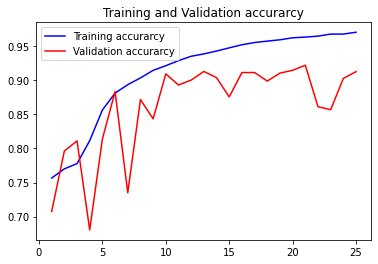

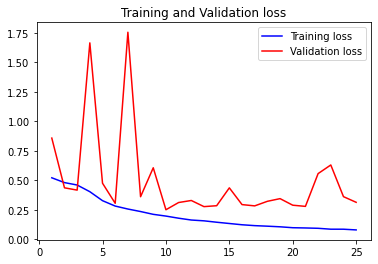

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
903/903 [==============================] - 2s 2ms/step
Test Accuracy: 91.27907156944275


In [ ]:
model.save_weights('/content/binary_model_weights')
model.save('/content/binary_model')

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/binary_model')
model.load_weights('/content/binary_model_weights')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open('/content/new_model.tflite', "wb").write(tflite_model)

89209448

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import tensorflow as tf

In [ ]:
print(tf.__version__)

2.2.0


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content')
tflite_model = converter.convert()
open('/content/model.tflite', "wb").write(tflite_model)

NameError: ignored

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(160, 160))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

Saving IMG_3222.jpg to IMG_3222.jpg
IMG_3222.jpg
[[1. 0. 0. 0.]]
